In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

In [2]:
import random
random.seed(42)
np.random.seed(42)

data = datasets.fetch_california_housing()
X = pd.DataFrame(data.data, columns = data.feature_names)
y = data.target
y = pd.Series(y)
y.index = X.index
print(str(len(X)) + ' rows')
print(str(len(X.columns)) + ' columns')

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.33, random_state=42)
xTrainScaler = preprocessing.StandardScaler()
xTrain = xTrainScaler.fit_transform(xTrain)
xTrain = pd.DataFrame(xTrain,columns = X.columns)
xTest = preprocessing.StandardScaler().fit_transform(xTest)
xTest = pd.DataFrame(xTest,columns = X.columns)
yTrain = preprocessing.StandardScaler().fit_transform(yTrain.values.reshape(-1, 1))
yTest = preprocessing.StandardScaler().fit_transform(yTest.values.reshape(-1, 1))
yTrain = pd.Series(yTrain.flatten())
yTrain.index = xTrain.index
yTest = pd.Series(yTest.flatten())
yTest.index = xTest.index

20640 rows
8 columns


# Package Details

## Installation:

ControlBurn can be installed via the Python Package Index PyPI (https://pypi.org/project/ControlBurn/) and is available for Python 3.7 and above. The following dependencies are required.

+ numpy (1.20.1)
+ pandas (1.2.4)
+ sklearn (0.24.1)

The source code for ControlBurn and additional updates can be found in the following repo: https://github.com/udellgroup/controlburn.

To install ControlBurn run the following command.

In [18]:
!pip install ControlBurn==0.1.1

  Attempting uninstall: ControlBurn
    Found existing installation: ControlBurn 0.1.0
    Uninstalling ControlBurn-0.1.0:
      Successfully uninstalled ControlBurn-0.1.0


## Quick Start

In the following section, we will demonstrate how to use ControlBurn to quickly select a sparse subset of features. We will use the California Housing Prices regression dataset from UCI MLR to illustrate this example. Our objective is to select a sparse subset of features from {MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, and Longitude} that predicts housing price.

Import ControlBurn via the following:

In [20]:
from ControlBurn.ControlBurnModel import ControlBurnRegressor #TODO change to github code when local changes are pushed

Fit a ControlBurn regressor that uses double bag-boosting to build the ensemble and LASSO to sparsify it.

In [21]:
cb = ControlBurnRegressor(build_forest_method = 'doublebagboost', alpha = 0.02)
cb.fit(xTrain,yTrain)

In [22]:
print('Number of trees grown: ' + str(len(cb.forest)))
print('Number of trees selected: ' + str(len(cb.subforest)))
print('Features selected ' + str(cb.features_selected_))

Number of trees grown: 76
Number of trees selected: 18
Features selected ['MedInc', 'Latitude', 'Longitude']


Out of the 79 trees grown, only 16 trees are selected. This subforest only uses the features MedInc, Latitude, and Longitude. MedInc represents the average earnings in a neighborhood a house is in, and Latitude and Longitude provides the location of the house. These features are very influential towards predicting housing prices. ControlBurn also fits a polished model on the selected features, the default model used for polishing is a random forest. When the predict function is called, the predictions of the polished model are returned.

In [23]:
pred = cb.predict(xTest)
print('MSE of polished sparse model: ' + str(mean_squared_error(yTest,pred)))

MSE of polished sparse model: 0.3436547242390613


In [24]:
#NOT INCLUDED
print('MSE of full model', mean_squared_error(yTest,
                                RandomForestRegressor(max_features = 'sqrt').fit(xTrain,yTrain).predict(xTest)))

MSE of full model 0.33466231722120393


In two lines of code, we obtain a feature-sparse model that performs comparably the full model on this split of data. ControlBurn is written to follow scikit-learn syntax for easy integratation into existing data science workflows.

## Interpretability Tools

ControlBurn provides the following interpretability tools to analyze the selected subforest. Import the following interpretability module and initialize and interpreter using the fitted ControlBurnRegressor object.

In [26]:
from ControlBurn.ControlBurnInterpret import InterpretRegressor
interpreter = InterpretRegressor(cb,xTrain,yTrain)

To give a sense of the structure of the selected subforest, this interpreter can list the features used in each tree of the subforest selected by our ControlBurnRegressor. 

In [27]:
features_used = interpreter.list_subforest(verbose = True)

['MedInc']
['MedInc']
['MedInc']
['MedInc']
['MedInc']
['MedInc']
['MedInc']
['MedInc']
['MedInc']
['MedInc']
['MedInc']
['MedInc']
['Latitude' 'Longitude']
['Latitude' 'Longitude']
['MedInc']
['Latitude' 'Longitude']
['Latitude' 'Longitude']
['Latitude' 'Longitude']


In this example, the feature MedInc appears in several trees. For single feature trees, we can use our interpreter to plot a shape function that shows how changes in the feature contribute to the response.

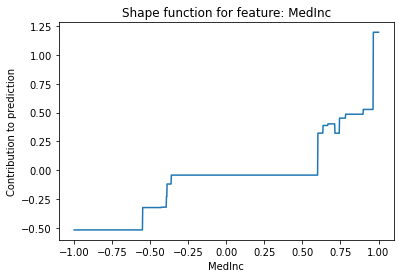

In [28]:
plot_single = interpreter.plot_single_feature_shape('MedInc')

The results are as expected, when the MedInc of a neighborhood is low, house prices are generally lower, as indicated by the -0.50 scaled contribution to the prediction. When the MedInc of the neighborhood is high, the contribution the impact on house prices is +1.25. This indicates that the effect of income on housing prices is more pronounced in high income neighborhoods.

In addition, the feature Latitude and Longitude appear in many trees together. We can use the interpret module to examine how this pairwise feature interaction impacts the prediction of the ensemble. 

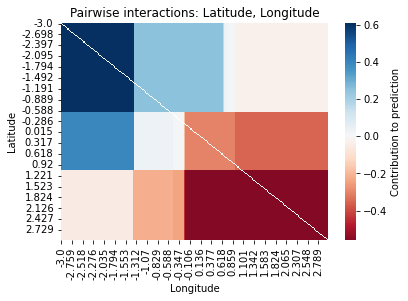

In [29]:
plot_pairwise = interpreter.plot_pairwise_interactions('Latitude','Longitude')

By varying the regularization parameter alpha, we can compute the entire regularization path and observe how features enter the support. This computation can be done very efficiently using warm-starts and the cost of computing the entire path is marginally higher than solving the LASSO problem once. Executing the code below compute the entire regularization path and plots how the feature importances of the subforest change with respect to alpha. The y-axis of the plot in Figure [ref] shows for each feature, the sum of feature importance contributed by each tree weighted by the LASSO solution coefficients. Unlike the linear LASSO coefficient regularization path, our feature importance paths are not necessarily monotonic. For example, in Figure [ref] when Latitude and Longitude drop out of the subforest, the remaining feature MedInc is assinged a higher weight and therefore a higher weighted feature importance score.

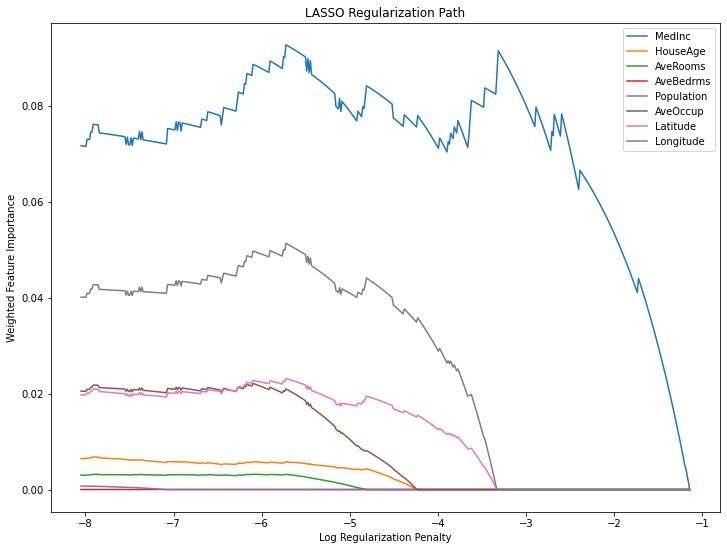

In [33]:
alphas,coef = cb.solve_lasso_path(xTrain,yTrain)
regularization_importances = interpreter.plot_regularization_path()

## Selecting the Regularization Parameter

ControlBurn can automatically select the optimal regularization parameter to use through computing the entire regularization path and evaluating the solutions on a k-fold cross validation of the training data. This can be done in the single line of code below.

best alpha: 0.010843240282163848
best feature sets: ('HouseAge', 'Latitude', 'Longitude', 'MedInc') 
 ('AveRooms', 'Latitude', 'Longitude', 'MedInc')


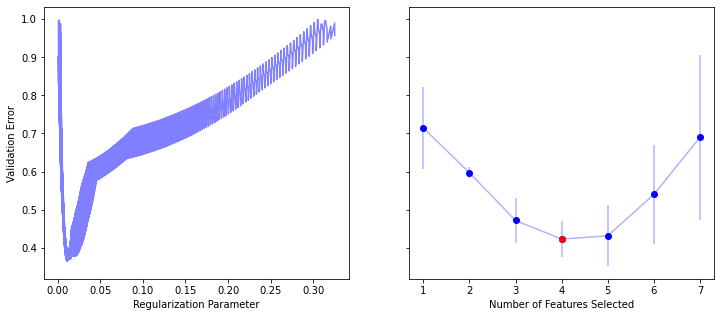

In [34]:
best_alpha, support_size, best_features = cb.fit_cv(xTrain,yTrain, 
                                                    verbose = True, kwargs = {'tol':0.001})
print('best alpha:', best_alpha)
print('best feature sets:', best_features[0],"\n", best_features[1])

In this example, ControlBurn selects a regularization parameter of 0.0103 which yield a four feature model. Latitude, Longitude, and MedInc are consistently selected as important features while AveOccup and HouseAge are included in the support across different folds. By calling the fit_cv function, ControlBurn automatically selects the optimal value of alpha and refits a tuned ControlBurnRegressor using that parameter. The features selected by the tuned model can be accessed with the command below.

In [35]:
print('Selected features: ', cb.features_selected_)

Selected features:  ['MedInc', 'HouseAge', 'AveOccup', 'Latitude', 'Longitude']
